# Data Processing Pipeline for beautofuel

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta

from packages.envirocar import TrackAPI, BboxSelector, TimeSelector, ECConfig
from packages.eda_quality import correction as correct
from packages.eda_quality import manipulation as manipulate
from packages.eda_quality import inspection as inspect

## Preparation

In [4]:
# How many days behind to look for new tracks
days_to_look_back=3

# Single track to pick to analyze from all the tracks
single_track_idx=0

# User
config = ECConfig(username="samko", password="someamazingtotallyrandomtoken")

track_api = TrackAPI()

## Query tracks

<AxesSubplot:>

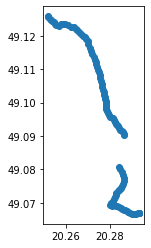

In [5]:
# Boundary box for Slovakia
bbox = BboxSelector([
    16.76425013529685, # min_x
    47.37325224412486, # min_y
    22.594816079401987, # max_x
    49.7297265173567 # max_y
])

# Tracks time interval
datetime_format = "%Y-%m-%dT%H:%M:%S+00:00"
start_time = datetime.today() - timedelta(days=days_to_look_back)
end_time = datetime.now()
time_interval = TimeSelector(start_time=start_time.strftime(datetime_format), end_time=end_time.strftime(datetime_format))

# Fetch from enviroCar API
tracks_df = track_api.get_tracks(bbox=bbox, time_interval=time_interval)

tracks_df.plot()

## Data cleaning and pre-processing
### Inspection and correction

Deleted rows:  0
no track duration exceeds eight hours
no track duration falls below 5 minutes
no track exceeds max speed 250km/h


<AxesSubplot:>

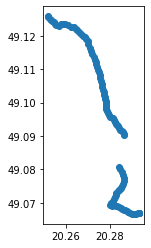

In [6]:
# Drop duplicated rows
tracks_df = correct.drop_dublicates(tracks_df)

# Remove tracks that exceed 8 hours of duration time
_, tracks_df, _ = correct.exceed_eight_hours(tracks_df, flag=False)

# Remove tracks that falls below 5 minutes of duration time
_, tracks_df, _ = correct.below_five_min(tracks_df, flag=False)

# Remove tracks that exceed 250 km/h speed
_, tracks_df, _ = correct.implausible_Max_Speed(tracks_df, flag=False)

tracks_df.plot()

### Pick one track

In [7]:
single_track_id = tracks_df['track.id'].unique()[single_track_idx]
track_df = tracks_df[tracks_df['track.id'] == single_track_id]
print("Selected track ID is {}".format(single_track_id))

Selected track ID is 6002d1a1886b71633cdd2fc9


### Manipulation a of the selected track

Dropped unit columns:  Index(['Consumption (GPS-based).unit', 'GPS Accuracy.unit', 'GPS Speed.unit',
       'CO2 Emission (GPS-based).unit', 'GPS Altitude.unit',
       'GPS Bearing.unit'],
      dtype='object')


<AxesSubplot:>

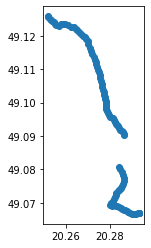

In [8]:
# Drop unit colums since we are not interested in them
manipulate.drop_unit_columns(track_df).head()

# Interpolate whole track data
# TODO Interpolate only missing data (e.g. track ID 6002d1a1886b71633cdd2fc9)
# track_df = manipulate.interpolate(track_df)

track_df.plot()

## OSM graph of "drive" streets above the selected track

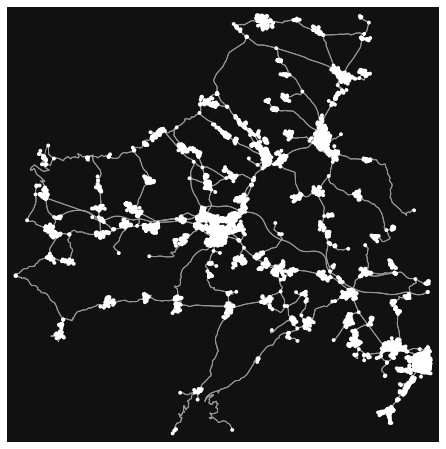

CPU times: user 8.86 s, sys: 253 ms, total: 9.11 s
Wall time: 9.29 s


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [9]:
%%time
import numpy as np
import osmnx as ox

# TODO - calculate centroid of track programmatically
lat = 49.0587587
lng = 20.2973094

# TODO - calculate distance from centroid programmatically
dist = 20000

graph = ox.graph_from_point((lat, lng), dist=dist, network_type='drive')

ox.plot_graph(graph)

## OSM graph transformation for compatibility with LMM

In [10]:
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.map.inmem import InMemMap

# Leuven Map Matching is using a different internal graph structure for the street data. 
# Therefore, the OSMnx graph needs to be transformed to the InMemMap
streetmap = InMemMap("enviroCar", use_latlon=True, use_rtree=True, index_edges=True)

# add nodes
nodes = list(graph.nodes)
for node in nodes:
    lng = graph.nodes[node]['x']
    lat = graph.nodes[node]['y']
    streetmap.add_node(node, (lat, lng))

# add edges
edges = list(graph.edges)
for edge in edges:
    node_a, node_b = edge[0], edge[1]
    streetmap.add_edge(node_a, node_b)
    
    # exclude bi-directional edges when street is oneway
    if not graph.edges[edge]['oneway']:
        streetmap.add_edge(node_b, node_a)
    
streetmap.purge()

## Map matching

In [11]:
# Get the latitude and longitude coordinates from the track and join them in an array
lats = list(track_df['geometry'].apply(lambda coord: coord.y))
lngs = list(track_df['geometry'].apply(lambda coord: coord.x))

track_coords = [c for c in zip(lats, lngs)]

In [27]:
%%time
# TODO Calculate programmatically
max_dist = 50

# Configure the mapmatcher. For increasing the performance it is important 
# that max_dist (in meters) is not set too high
matcher = DistanceMatcher(streetmap,
                          max_dist=max_dist, 
                          max_dist_init=50,
                          min_prob_norm=0.9,
                          non_emitting_length_factor=0.75,
                          obs_noise=50,
                          obs_noise_ne=75,
                          dist_noise=50,
                          non_emitting_edgeid=False)

# Perform the mapmatching 
edge_ids, last_idx = matcher.match(track_coords)

Exception: Did not find a matching node for path point at index 6

## Result

In [16]:
import folium

# get the coordinates of the "best" mapmatched route
coords = [m.edge_m.pi[:] for m in matcher.lattice_best]

# plot both raw and mapmatched track
m = folium.Map(location=[lat, lng], zoom_start=13)
folium.PolyLine(coords, color='blue').add_to(m)
folium.PolyLine(track_coords, color='red').add_to(m)
m